# Link utili

#https://medium.com/uxness/survey-research-ways-to-clean-survey-data-before-analysis-52c1c6309754

# Ricordrsi di rendere ordinale l'istruzione

https://www.statology.org/cronbachs-alpha-in-python/

# Dataset loading

In [1]:
import pandas as pd
import numpy as np
import json
import requests

In [2]:
gcbs_df = pd.read_csv('https://raw.githubusercontent.com/bolps/conspiracy/main/openpsychometrics_gcbs_data.csv')

In [3]:
gcbs_df.head(5)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,engnat,age,hand,religion,orientation,race,voted,married,familysize,major
0,5,5,3,5,5,5,5,3,4,5,...,2,28,1,2,1,5,2,1,1,ACTING
1,5,5,5,5,5,3,5,5,1,4,...,1,14,1,1,2,4,2,1,1,NaN
2,2,4,1,2,2,2,4,2,2,4,...,2,26,1,1,1,4,1,1,2,philosophy
3,5,4,1,2,4,5,4,1,4,5,...,1,25,1,12,1,4,1,1,3,history
4,5,4,1,4,4,5,4,3,1,5,...,1,37,1,2,2,4,2,2,2,Psychology


In [4]:
gcbs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 72 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Q1            2495 non-null   int64 
 1   Q2            2495 non-null   int64 
 2   Q3            2495 non-null   int64 
 3   Q4            2495 non-null   int64 
 4   Q5            2495 non-null   int64 
 5   Q6            2495 non-null   int64 
 6   Q7            2495 non-null   int64 
 7   Q8            2495 non-null   int64 
 8   Q9            2495 non-null   int64 
 9   Q10           2495 non-null   int64 
 10  Q11           2495 non-null   int64 
 11  Q12           2495 non-null   int64 
 12  Q13           2495 non-null   int64 
 13  Q14           2495 non-null   int64 
 14  Q15           2495 non-null   int64 
 15  E1            2495 non-null   int64 
 16  E2            2495 non-null   int64 
 17  E3            2495 non-null   int64 
 18  E4            2495 non-null   int64 
 19  E5    

# Data munging

Before starting the whole process of data cleaning and analysis, raw data must be trasformed in the most convenient way for the upcoming steps.

The following munging process includes:
* dropping useless columns
* assigning the correct data type
* labelling categorical data (according to the codebook)
* identifying missing values (according to the codebook)
* grouping values from text fields
* renaming columns (with prefixes for better organization)
* computing variables for survey cleaning (straightliners, speed responses, outliers, validity check errors)
* scoring GCBS and TIPI (according to literature). *This step is crucial as it allows us to transform raw data (indicators) into a value (score) that reflects an individual's position on an underlying construct (such as personality or beliefs)*

In [5]:
# dropping 'introelapse','testelapse','surveyelapse' (overall time spent in every block) columns as I'm not going to use them
gcbs_df = gcbs_df.drop(['introelapse','testelapse','surveyelapse'], axis=1)

In [6]:
# download/parsing json labels 
survey_labels_json = requests.get("https://raw.githubusercontent.com/bolps/conspiracy/main/survey_labels.json")
survey_labels_dict = json.loads(survey_labels_json.text)

In [7]:
# mapping labels on dataframe, converting 'Missing' label to NaN, casting to 'category' (or ordered category) data type
for column in ['education','urban','gender','engnat','hand','religion','orientation','race','voted','married']:
  gcbs_df[column] = gcbs_df[column].astype(str).map(survey_labels_dict[column])
  gcbs_df[column] = gcbs_df[column].replace('Missing', np.nan)
  gcbs_df[column] = gcbs_df[column].astype("category")
gcbs_df['education'] = gcbs_df['education'].cat.reorder_categories(['Less than high school', 'High school', 'University degree', 'Graduate degree'], ordered=True)

In [8]:
# assigning NaN to values which makes no sense (i.e. too old or too young people)
gcbs_df['familysize'] = gcbs_df['familysize'].replace(0, np.nan)
gcbs_df.loc[gcbs_df.familysize > 10, 'familysize'] = np.nan
gcbs_df.loc[gcbs_df.age > 90, 'age'] = np.nan
gcbs_df.loc[gcbs_df.age < 10, 'age'] = np.nan
gcbs_df.loc[gcbs_df.education < 'University degree', 'major'] = np.nan

In [9]:
# Normalizing text for the field major (free-form). Example: '           aCTING' = 'Acting', 'ACTING' = 'Acting'
gcbs_df['major'] = gcbs_df['major'].map(lambda x : x.strip().capitalize() if isinstance(x, str) else np.nan)

In [10]:
# download/parsing json labels. Major labels has been manually grouped in macro-categories
major_labels_json = requests.get("https://raw.githubusercontent.com/bolps/conspiracy/main/major_labels.json")
major_labels_dict = json.loads(major_labels_json.text)

In [11]:
# mapping labels on dataframe in order to crate a new column with the 'major cluster'. Example: Graphic design (Major) - Arts (Cluster) 
gcbs_df['major_cluster'] = gcbs_df['major'].map(major_labels_dict['Cluster'])
gcbs_df['major_cluster'] = gcbs_df['major_cluster'].replace('Missing', np.nan)
gcbs_df['major_cluster'] = gcbs_df['major_cluster'].astype("category")

In [12]:
# renaming GCBS items for consistency and readability (columns Q1-Q15 belongs to GCBS scale). Example: Q1 becomes GCBS1
gcbs_df.columns = [column.replace('Q', 'GCBS') for column in gcbs_df.columns]

In [13]:
# computing scores for GCBS scale and subscales according to the codebook. Note: GCBS scale doesn't use reverse items.
gcbs_df['GCBS_Government_Malfeasance'] = gcbs_df['GCBS1'] + gcbs_df['GCBS6'] + gcbs_df['GCBS11']
gcbs_df['GCBS_Malevolent_Global_Conspiracies'] = gcbs_df['GCBS2'] + gcbs_df['GCBS7'] + gcbs_df['GCBS12']
gcbs_df['GCBS_Extraterrestrial_Coverup'] = gcbs_df['GCBS3'] + gcbs_df['GCBS8'] + gcbs_df['GCBS13']
gcbs_df['GCBS_Personal_Wellbeing'] = gcbs_df['GCBS4'] + gcbs_df['GCBS9'] + gcbs_df['GCBS14']
gcbs_df['GCBS_Control_Of_Information'] = gcbs_df['GCBS5'] + gcbs_df['GCBS10'] + gcbs_df['GCBS15']
gcbs_df['GCBS_Overall'] = gcbs_df['GCBS_Government_Malfeasance'] + gcbs_df['GCBS_Malevolent_Global_Conspiracies'] + gcbs_df['GCBS_Extraterrestrial_Coverup'] + gcbs_df['GCBS_Personal_Wellbeing'] + gcbs_df['GCBS_Control_Of_Information']

In [14]:
# computing scores for TIPI (personality) scale and subscales according to the codebook. Note: Some of the items are reversed (formula for reversing: reversed = (number_of_levels + 1) - raw_value).
gcbs_df['TIPI_Extraversion'] = gcbs_df['TIPI1'] + (8-gcbs_df['TIPI6'])
gcbs_df['TIPI_Agreeableness'] = (8-gcbs_df['TIPI2']) + gcbs_df['TIPI7']
gcbs_df['TIPI_Conscientiousness'] = gcbs_df['TIPI3'] + (8-gcbs_df['TIPI8'])
gcbs_df['TIPI_Emotional_Stability'] = (8-gcbs_df['TIPI4']) + gcbs_df['TIPI9']
gcbs_df['TIPI_Openness'] = gcbs_df['TIPI5'] + (8-gcbs_df['TIPI10'])

In [15]:
# computing variable for counting validity check errors (validity check items are simple questions used to probe user attention and engagement)
gcbs_df['SURV_ValidityCheck_Errors'] = gcbs_df['VCL6'] + gcbs_df['VCL9'] + gcbs_df['VCL12']
gcbs_df = gcbs_df.drop(['VCL1','VCL2','VCL3','VCL4','VCL5','VCL6','VCL7','VCL8','VCL9','VCL10','VCL11','VCL12','VCL13','VCL14','VCL15','VCL16'], axis=1)

In [16]:
# computing variable to spot straightliners for GCBS (respondents who selected the same answer to all items of the scale).
# the respondent is a straightliner if the std deviation of the scale is 0 (always the same answer)
gcbs_df['SURV_CheckStraightliners_GCBS'] = gcbs_df[['GCBS1','GCBS2','GCBS3','GCBS4','GCBS5','GCBS6','GCBS7','GCBS8','GCBS9','GCBS10','GCBS11','GCBS12','GCBS13','GCBS14','GCBS15']].std(axis=1)
gcbs_df['SURV_CheckStraightliners_GCBS'] = gcbs_df['SURV_CheckStraightliners_GCBS'] == 0

In [17]:
# computing variable to spot straightliners for TIPI (respondents who selected the same answer to all items of the scale).
# the respondent is a straightliner if the std deviation of the scale is 0 (always the same answer)
gcbs_df['SURV_CheckStraightliners_TIPI'] = gcbs_df[['TIPI1','TIPI2','TIPI3','TIPI4','TIPI5','TIPI6','TIPI7','TIPI8','TIPI9','TIPI10']].std(axis=1)
gcbs_df['SURV_CheckStraightliners_TIPI'] = gcbs_df['SURV_CheckStraightliners_TIPI'] == 0

In [18]:
# computing variable to spot speed responses for GCBS (the core construct measured). Note: Unfortunately we have no data on TIPI response times.
# I considered a speed response if the response time of at least one item of the scale is less than the 5th quantile. Note: I dropped response times as I don't need them anymore
for item in ['E1','E2','E3','E4','E5','E6','E7','E8','E9','E10','E11','E12','E13','E14','E15']:
  gcbs_df[item] = gcbs_df[item] < gcbs_df[item].quantile(.05)
gcbs_df['SURV_QuickResponse_GCBS'] = gcbs_df[['E1','E2','E3','E4','E5','E6','E7','E8','E9','E10','E11','E12','E13','E14','E15']].any(axis=1)
gcbs_df = gcbs_df.drop(['E1','E2','E3','E4','E5','E6','E7','E8','E9','E10','E11','E12','E13','E14','E15'], axis=1)

In [19]:
# renaming columns for better organization.
# I logically divided data in blocks: RAW (raw GCBS and TIPI data), DEMO (demographics), GCBS (gcbs scores), TIPI (tipi scores) and SURV (survey related info)
gcbs_df.columns = [('RAW_'+column) for column in gcbs_df.columns[:gcbs_df.columns.get_loc('TIPI10')+1]] + [('DEMO_'+column) for column in gcbs_df.columns[gcbs_df.columns.get_loc('TIPI10')+1:gcbs_df.columns.get_loc('major_cluster')+1]] + list(gcbs_df.columns[gcbs_df.columns.get_loc('major_cluster')+1:])

In [20]:
gcbs_df.head(5).T

,0,1,2,3,4
RAW_GCBS1,5,5,2,5,5
RAW_GCBS2,5,5,4,4,4
RAW_GCBS3,3,5,1,1,1
RAW_GCBS4,5,5,2,2,4
RAW_GCBS5,5,5,2,4,4
RAW_GCBS6,5,3,2,5,5
RAW_GCBS7,5,5,4,4,4
RAW_GCBS8,3,5,2,1,3
RAW_GCBS9,4,1,2,4,1
RAW_GCBS10,5,4,4,5,5


In [21]:
gcbs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 54 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   RAW_GCBS1                            2495 non-null   int64   
 1   RAW_GCBS2                            2495 non-null   int64   
 2   RAW_GCBS3                            2495 non-null   int64   
 3   RAW_GCBS4                            2495 non-null   int64   
 4   RAW_GCBS5                            2495 non-null   int64   
 5   RAW_GCBS6                            2495 non-null   int64   
 6   RAW_GCBS7                            2495 non-null   int64   
 7   RAW_GCBS8                            2495 non-null   int64   
 8   RAW_GCBS9                            2495 non-null   int64   
 9   RAW_GCBS10                           2495 non-null   int64   
 10  RAW_GCBS11                           2495 non-null   int64   
 11  RAW_GCBS12       

In [22]:
gcbs_df.isnull().sum()[gcbs_df.isnull().sum() > 0]

DEMO_education          38
DEMO_urban              39
DEMO_gender              6
DEMO_engnat              8
DEMO_age                 2
DEMO_hand               13
DEMO_religion           31
DEMO_orientation        39
DEMO_race               25
DEMO_voted              23
DEMO_married            16
DEMO_familysize         53
DEMO_major            1561
DEMO_major_cluster    1578
dtype: int64

In [23]:
gcbs_df.describe().T

,count,mean,std,min,25%,50%,75%,max
RAW_GCBS1,2495.0,3.472545,1.455552,0.0,2.0,4.0,5.0,5.0
RAW_GCBS2,2495.0,2.963527,1.494669,0.0,2.0,3.0,4.0,5.0
RAW_GCBS3,2495.0,2.046894,1.387236,0.0,1.0,1.0,3.0,5.0
RAW_GCBS4,2495.0,2.636072,1.451371,0.0,1.0,2.0,4.0,5.0
RAW_GCBS5,2495.0,3.254108,1.471855,0.0,2.0,4.0,5.0,5.0
RAW_GCBS6,2495.0,3.108617,1.506676,0.0,2.0,3.0,4.0,5.0
RAW_GCBS7,2495.0,2.666934,1.509954,0.0,1.0,2.0,4.0,5.0
RAW_GCBS8,2495.0,2.450501,1.569256,0.0,1.0,2.0,4.0,5.0
RAW_GCBS9,2495.0,2.232866,1.419266,0.0,1.0,2.0,3.0,5.0
RAW_GCBS10,2495.0,3.502204,1.388713,1.0,2.0,4.0,5.0,5.0


# Data cleaning

* Esclusione dei partecipanti con età inferiore a 18 anni in quanto la scala GCBS è validata solo per 18+
* Esclusione dei partecipanti che hanno dato risposte veloci, hanno fallito i validity check o hanno dato risposte straightline
* Rimozione di eventuali duplicati
* Ouliers in social science https://methods.sagepub.com/reference/encyc-of-research-design/n296.xml#:~:text=An%20outlier%20can%20represent%20a,the%20part%20of%20the%20experimenter.

In [24]:
age_mask = gcbs_df['DEMO_age'] >= 18
validity_check_erros_mask = gcbs_df['SURV_ValidityCheck_Errors'] == 0
check_straightliners_gcbs_mask = gcbs_df['SURV_CheckStraightliners_GCBS'] == False
check_straightliners_tipi_mask = gcbs_df['SURV_CheckStraightliners_TIPI'] == False
quick_response_gcbs_mask = gcbs_df['SURV_QuickResponse_GCBS'] == False

In [25]:
gcbs_clean_df = gcbs_df[age_mask & validity_check_erros_mask & check_straightliners_gcbs_mask & check_straightliners_tipi_mask & quick_response_gcbs_mask]
gcbs_clean_df = gcbs_clean_df.reset_index(drop=True)
gcbs_clean_df = gcbs_clean_df.drop(['SURV_ValidityCheck_Errors','SURV_CheckStraightliners_GCBS','SURV_CheckStraightliners_TIPI','SURV_QuickResponse_GCBS'], axis=1)

In [26]:
gcbs_clean_df.head(5).T

,0,1,2,3,4
RAW_GCBS1,5,5,5,5,4
RAW_GCBS2,5,4,4,4,4
RAW_GCBS3,3,1,3,2,1
RAW_GCBS4,5,4,3,4,3
RAW_GCBS5,5,4,4,5,4
RAW_GCBS6,5,5,5,5,2
RAW_GCBS7,5,4,5,3,4
RAW_GCBS8,3,3,5,3,1
RAW_GCBS9,4,1,5,5,1
RAW_GCBS10,5,5,5,3,4


In [27]:
gcbs_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 50 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   RAW_GCBS1                            962 non-null    int64   
 1   RAW_GCBS2                            962 non-null    int64   
 2   RAW_GCBS3                            962 non-null    int64   
 3   RAW_GCBS4                            962 non-null    int64   
 4   RAW_GCBS5                            962 non-null    int64   
 5   RAW_GCBS6                            962 non-null    int64   
 6   RAW_GCBS7                            962 non-null    int64   
 7   RAW_GCBS8                            962 non-null    int64   
 8   RAW_GCBS9                            962 non-null    int64   
 9   RAW_GCBS10                           962 non-null    int64   
 10  RAW_GCBS11                           962 non-null    int64   
 11  RAW_GCBS12         

In [28]:
gcbs_clean_df.describe().T

,count,mean,std,min,25%,50%,75%,max
RAW_GCBS1,962.0,3.598753,1.366737,1.0,3.0,4.0,5.0,5.0
RAW_GCBS2,962.0,3.099792,1.444938,1.0,2.0,3.0,4.0,5.0
RAW_GCBS3,962.0,1.918919,1.281289,1.0,1.0,1.0,3.0,5.0
RAW_GCBS4,962.0,2.663202,1.414536,1.0,1.0,3.0,4.0,5.0
RAW_GCBS5,962.0,3.330561,1.424069,1.0,2.0,4.0,5.0,5.0
RAW_GCBS6,962.0,3.185031,1.440121,1.0,2.0,3.0,4.0,5.0
RAW_GCBS7,962.0,2.794179,1.501732,1.0,1.0,3.0,4.0,5.0
RAW_GCBS8,962.0,2.386694,1.517895,1.0,1.0,2.0,4.0,5.0
RAW_GCBS9,962.0,2.286902,1.406398,1.0,1.0,2.0,3.0,5.0
RAW_GCBS10,962.0,3.576923,1.316195,1.0,3.0,4.0,5.0,5.0


# Data quality

Alpha di cronbach

The reliability of a two-item scale: Pearson, Cronbach,
or Spearman-Brown? -- per cronbach su scale da due item (per questo tipo di scale cronbach sottostima)

Eisinga, Rob; Grotenhuis, Manfred te; Pelzer, Ben (2013). *The reliability of a two-item scale: Pearson, Cronbach, or Spearman-Brown?. International Journal of Public Health, 58(4), 637–642.* [doi:10.1007/s00038-012-0416-3](https://link.springer.com/article/10.1007%2Fs00038-012-0416-3)

In [29]:
%%capture
!pip install pingouin
pd.options.display.max_colwidth = 100

In [30]:
def getCronbachDict(scale_name,df, ci=.95):

  import pingouin as pg
  cron = pg.cronbach_alpha(data=df)

  if cron[0] >= 0.9:
    internal_consistency = 'Excellent'
  elif cron[0] >= 0.8:
    internal_consistency = 'Good'
  elif cron[0] >= 0.7:
    internal_consistency = 'Acceptable'
  elif cron[0] >= 0.6:
    internal_consistency = 'Questionable'
  elif cron[0] >= 0.5:
    internal_consistency = 'Poor'
  else:
    internal_consistency = 'Unacceptable'

  if len(df.columns) == 2:
    note = 'When items = 2, coefficient alpha almost always underestimates true reliability'
  else:
    note = ''

  return {
      'scale':scale_name,
      'scale_items':len(df.columns),
      'sample_size':len(df),
      'cronbach_alpha':round(cron[0],3),
      'ci_lower':cron[1][0],
      'ci_upper':cron[1][1],
      'ci':ci,
      'internal_consistency':internal_consistency,
      'note':note
  }

In [31]:
cronbach_dict_list = []

In [32]:
cronbach_dict_list.append(getCronbachDict('GCBS_Overall',gcbs_clean_df[['RAW_GCBS1','RAW_GCBS2','RAW_GCBS3','RAW_GCBS4','RAW_GCBS5','RAW_GCBS6','RAW_GCBS7','RAW_GCBS8','RAW_GCBS9','RAW_GCBS10','RAW_GCBS11','RAW_GCBS12','RAW_GCBS13','RAW_GCBS14','RAW_GCBS15']]))
cronbach_dict_list.append(getCronbachDict('GCBS_Government_Malfeasance',gcbs_clean_df[['RAW_GCBS1','RAW_GCBS6','RAW_GCBS11']]))
cronbach_dict_list.append(getCronbachDict('GCBS_Malevolent_Global_Conspiracies',gcbs_clean_df[['RAW_GCBS2','RAW_GCBS7','RAW_GCBS12']]))
cronbach_dict_list.append(getCronbachDict('GCBS_Extraterrestrial_Coverup',gcbs_clean_df[['RAW_GCBS3','RAW_GCBS8','RAW_GCBS13']]))
cronbach_dict_list.append(getCronbachDict('GCBS_Personal_Wellbeing',gcbs_clean_df[['RAW_GCBS4','RAW_GCBS9','RAW_GCBS14']]))
cronbach_dict_list.append(getCronbachDict('GCBS_Control_Of_Information',gcbs_clean_df[['RAW_GCBS5','RAW_GCBS10','RAW_GCBS15']]))

In [33]:
# spiegare perchè rev
for column in ['RAW_TIPI2','RAW_TIPI4','RAW_TIPI6','RAW_TIPI8','RAW_TIPI10']:
  gcbs_clean_df['{}_REV'.format(column)] = 8-gcbs_clean_df[column]

cronbach_dict_list.append(getCronbachDict('TIPI_Overall',gcbs_clean_df[['RAW_TIPI1','RAW_TIPI2_REV','RAW_TIPI3','RAW_TIPI4_REV','RAW_TIPI5','RAW_TIPI6_REV','RAW_TIPI7','RAW_TIPI8_REV','RAW_TIPI9','RAW_TIPI10_REV']]))
cronbach_dict_list.append(getCronbachDict('TIPI_Extraversion',gcbs_clean_df[['RAW_TIPI1','RAW_TIPI6_REV']]))
cronbach_dict_list.append(getCronbachDict('TIPI_Agreeableness',gcbs_clean_df[['RAW_TIPI2_REV','RAW_TIPI7']]))
cronbach_dict_list.append(getCronbachDict('TIPI_Conscientiousness',gcbs_clean_df[['RAW_TIPI3','RAW_TIPI8_REV']]))
cronbach_dict_list.append(getCronbachDict('TIPI_Emotional_Stability',gcbs_clean_df[['RAW_TIPI4_REV','RAW_TIPI9']]))
cronbach_dict_list.append(getCronbachDict('TIPI_Openness',gcbs_clean_df[['RAW_TIPI5','RAW_TIPI10_REV']]))

# cancellare rev

In [34]:
cronbach_df  = pd.DataFrame(cronbach_dict_list)
cronbach_df

,scale,scale_items,sample_size,cronbach_alpha,ci_lower,ci_upper,ci,internal_consistency,note
0,GCBS_Overall,15,962,0.924,0.916,0.931,0.95,Excellent,
1,GCBS_Government_Malfeasance,3,962,0.798,0.775,0.819,0.95,Acceptable,
2,GCBS_Malevolent_Global_Conspiracies,3,962,0.886,0.872,0.898,0.95,Good,
3,GCBS_Extraterrestrial_Coverup,3,962,0.883,0.870,0.896,0.95,Good,
4,GCBS_Personal_Wellbeing,3,962,0.793,0.770,0.815,0.95,Acceptable,
5,GCBS_Control_Of_Information,3,962,0.620,0.576,0.660,0.95,Questionable,
6,TIPI_Overall,10,962,0.636,0.600,0.669,0.95,Questionable,
7,TIPI_Extraversion,2,962,0.752,0.718,0.781,0.95,Acceptable,"When items = 2, coefficient alpha almost always underestimates true reliability"
8,TIPI_Agreeableness,2,962,0.374,0.290,0.449,0.95,Unacceptable,"When items = 2, coefficient alpha almost always underestimates true reliability"
9,TIPI_Conscientiousness,2,962,0.623,0.572,0.668,0.95,Questionable,"When items = 2, coefficient alpha almost always underestimates true reliability"


# Data Exploration

In [35]:
import matplotlib.pyplot as plt

#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

### Sample description

In [36]:
total_responses = sum(gcbs_clean_df['DEMO_age'].value_counts())
gcbs_clean_df['DEMO_age'].iplot(kind='hist', opacity=0.75, color='rgb(12, 128, 128)', title='Age Distribtution (N={})'.format(total_responses), yTitle='Count', xTitle='Age', bargap = 0, theme='white')

In [37]:
total_responses = sum(gcbs_clean_df['DEMO_education'].value_counts())
gcbs_clean_df['DEMO_education'].value_counts().sort_index(ascending=True).iplot(kind='bar', title='Education (N={})'.format(total_responses), theme='white')

In [38]:
family_distribution = gcbs_clean_df['DEMO_familysize'].value_counts().sort_index(ascending=True)
family_distribution.index = [int(i) for i in list(family_distribution.index)]
total_responses = sum(family_distribution)
family_distribution.iplot(kind='bar', title='Family size (N={})'.format(total_responses), theme='white')

In [39]:
total_responses = sum(gcbs_clean_df['DEMO_urban'].value_counts())
urban_df = gcbs_clean_df['DEMO_urban'].value_counts().rename_axis('DEMO_urban').reset_index(name='counts')
urban_df.iplot(kind='pie', labels='DEMO_urban', values='counts', title='Area (N={})'.format(total_responses), hoverinfo="label+percent+name", hole=0.3, theme='white')

In [40]:
total_responses = sum(gcbs_clean_df['DEMO_gender'].value_counts())
gender_df = gcbs_clean_df['DEMO_gender'].value_counts().rename_axis('DEMO_gender').reset_index(name='counts')
gender_df.iplot(kind='pie', labels='DEMO_gender', values='counts', title='Gender (N={})'.format(total_responses), hoverinfo="label+percent+name", hole=0.3, theme='white')

In [41]:
total_responses = sum(gcbs_clean_df['DEMO_engnat'].value_counts())
lang_df = gcbs_clean_df['DEMO_engnat'].value_counts().rename_axis('DEMO_engnat').reset_index(name='counts')
lang_df.iplot(kind='pie', labels='DEMO_engnat', values='counts', title='Language (N={})'.format(total_responses), hoverinfo="label+percent+name", hole=0.3, theme='white')

In [42]:
total_responses = sum(gcbs_clean_df['DEMO_hand'].value_counts())
hand_df = gcbs_clean_df['DEMO_hand'].value_counts().rename_axis('DEMO_hand').reset_index(name='counts')
hand_df.iplot(kind='pie', labels='DEMO_hand', values='counts', title='Hand preference (N={})'.format(total_responses), hoverinfo="label+percent+name", hole=0.3, theme='white')

In [43]:
total_responses = sum(gcbs_clean_df['DEMO_religion'].value_counts()[gcbs_clean_df['DEMO_religion'].value_counts()> 0])
religion_df = gcbs_clean_df['DEMO_religion'].value_counts()[gcbs_clean_df['DEMO_religion'].value_counts()> 0].rename_axis('DEMO_religion').reset_index(name='counts')
religion_df.iplot(kind='pie', labels='DEMO_religion', values='counts', title='Religion (N={})'.format(total_responses), hoverinfo="label+percent+name", hole=0.3, theme='white')

In [44]:
total_responses = sum(gcbs_clean_df['DEMO_orientation'].value_counts())
orientation_df = gcbs_clean_df['DEMO_orientation'].value_counts().rename_axis('DEMO_orientation').reset_index(name='counts')
orientation_df.iplot(kind='pie', labels='DEMO_orientation', values='counts', title='Sexual orientation (N={})'.format(total_responses), hoverinfo="label+percent+name", hole=0.3, theme='white')

In [45]:
total_responses = sum(gcbs_clean_df['DEMO_race'].value_counts())
race_df = gcbs_clean_df['DEMO_race'].value_counts().rename_axis('DEMO_race').reset_index(name='counts')
race_df.iplot(kind='pie', labels='DEMO_race', values='counts', title='Race (N={})'.format(total_responses), hoverinfo="label+percent+name", hole=0.3, theme='white')

In [46]:
total_responses = sum(gcbs_clean_df['DEMO_voted'].value_counts())
vote_df = gcbs_clean_df['DEMO_voted'].value_counts().rename_axis('DEMO_voted').reset_index(name='counts')
vote_df.iplot(kind='pie', labels='DEMO_voted', values='counts', title='Voted (N={})'.format(total_responses), hoverinfo="label+percent+name", hole=0.3, theme='white')

In [47]:
total_responses = sum(gcbs_clean_df['DEMO_married'].value_counts())
married_df = gcbs_clean_df['DEMO_married'].value_counts().rename_axis('DEMO_married').reset_index(name='counts')
married_df.iplot(kind='pie', labels='DEMO_married', values='counts', title='Married (N={})'.format(total_responses), hoverinfo="label+percent+name", hole=0.3, theme='white')

In [48]:
total_responses = sum(gcbs_clean_df['DEMO_major_cluster'].value_counts())
major_df = gcbs_clean_df['DEMO_major_cluster'].value_counts().rename_axis('DEMO_major_cluster').reset_index(name='counts')
major_df.iplot(kind='pie', labels='DEMO_major_cluster', values='counts', title='Major (N={})'.format(total_responses), hoverinfo="label+percent+name", hole=0.3, theme='white')

### Univariate analysis

***Research questions:***
* *Are beliefs in conspiracy theories normally distributed among the sample?*
* *What is the strongest conspiracy theory among Government Malfeasance, Extraterrestrial Cover-up, Malevolent Global Conspiracies, Personal Wellbeing, and Control of Information?*

In [49]:
gcbs_clean_df['GCBS_Overall'].iplot(kind='hist', opacity=0.75, color='rgb(12, 128, 128)', title='Generic Conspiracist Beliefs Scale Distribution'.format(total_responses), yTitle='Count', xTitle='GCBS score (overall)', bargap = 0, theme='white')

In [50]:
gcbs_clean_df['GCBS_Government_Malfeasance'].iplot(kind='hist', opacity=0.75, color='rgb(12, 128, 128)', title='Government Malfeasance Subscale Distribution'.format(total_responses), yTitle='Count', xTitle='GCBS score (overall)', bargap = 0, theme='white')

In [51]:
gcbs_clean_df['GCBS_Malevolent_Global_Conspiracies'].iplot(kind='hist', opacity=0.75, color='rgb(12, 128, 128)', title='Malevolent Global Conspiracies Subscale Distribution'.format(total_responses), yTitle='Count', xTitle='GCBS score (overall)', bargap = 0, theme='white')

In [52]:
gcbs_clean_df['GCBS_Extraterrestrial_Coverup'].iplot(kind='hist', opacity=0.75, color='rgb(12, 128, 128)', title='Extraterrestrial Coverup Subscale Distribution'.format(total_responses), yTitle='Count', xTitle='GCBS score (overall)', bargap = 0, theme='white')

In [53]:
gcbs_clean_df['GCBS_Personal_Wellbeing'].iplot(kind='hist', opacity=0.75, color='rgb(12, 128, 128)', title='Personal Wellbeing Subscale Distribution'.format(total_responses), yTitle='Count', xTitle='GCBS score (overall)', bargap = 0, theme='white')

In [54]:
gcbs_clean_df['GCBS_Control_Of_Information'].iplot(kind='hist', opacity=0.75, color='rgb(12, 128, 128)', title='Control Of Information Subscale Distribution'.format(total_responses), yTitle='Count', xTitle='GCBS score (overall)', bargap = 0, theme='white')

In [55]:
gcbs_clean_df[['GCBS_Government_Malfeasance','GCBS_Malevolent_Global_Conspiracies', 'GCBS_Extraterrestrial_Coverup','GCBS_Personal_Wellbeing', 'GCBS_Control_Of_Information']].iplot(kind='box', title='Comparing beliefs in conspiracy theories', theme='white')

### Bivariate analysis

***Research questions:***
* *Is there a relationship between beliefs in conspiracy theories?* è bivariata???
* *Is there a relationship between beliefs in conspiracy theories and personality?*

In [58]:
import seaborn as sns

In [59]:
def getHeatmap(df, title):
    corr_matrix = df.corr()
    
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)]= True
    mask[np.triu_indices_from(mask)]= True
    
    f, ax = plt.subplots(figsize=(11, 15)) 
    heatmap = sns.heatmap(corr_matrix,
                          mask = mask,
                          square = True,
                          linewidths = .5,
                          cmap = 'RdBu',
                          cbar_kws = {'shrink': .4, 
                                    'ticks' : [-1, -.5, 0, 0.5, 1]},
                          vmin = -1, 
                          vmax = 1,
                          annot = True,
                          annot_kws = {'size': 12})
    
    ax.set_yticklabels(corr_matrix.columns, rotation = 0)
    ax.set_xticklabels(corr_matrix.columns)
    ax.set_title(title)
    sns.set_style({'xtick.bottom': True}, {'ytick.left': True})


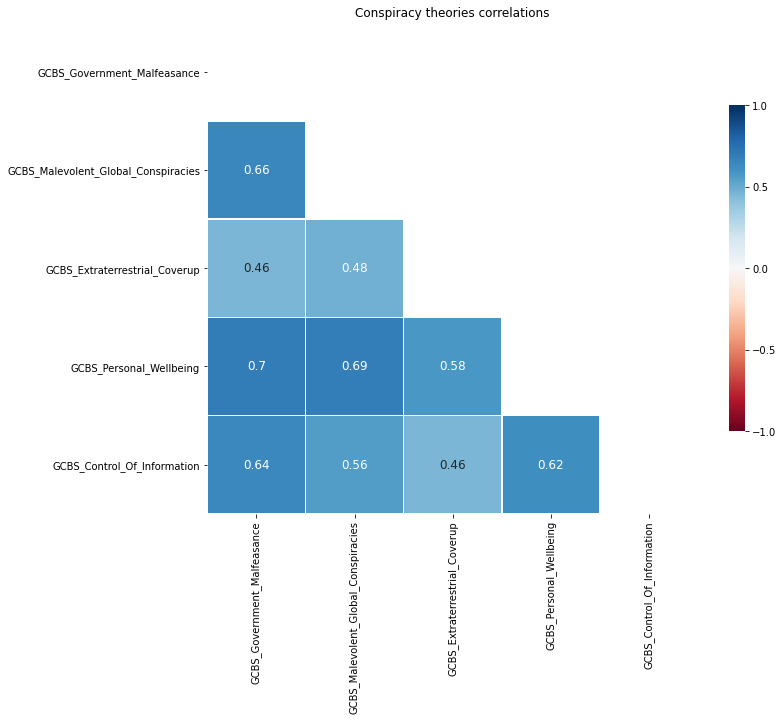

In [60]:
getHeatmap(gcbs_clean_df[['GCBS_Government_Malfeasance','GCBS_Malevolent_Global_Conspiracies', 'GCBS_Extraterrestrial_Coverup','GCBS_Personal_Wellbeing', 'GCBS_Control_Of_Information']], 'Conspiracy theories correlations')

In [77]:
for personality_dimension in list(gcbs_clean_df.filter(like='TIPI_',axis=1).columns):
    for conspiracy_theory in list(gcbs_clean_df.filter(like='GCBS_',axis=1).columns):
        print(personality_dimension, conspiracy_theory)

TIPI_Extraversion GCBS_Government_Malfeasance
TIPI_Extraversion GCBS_Malevolent_Global_Conspiracies
TIPI_Extraversion GCBS_Extraterrestrial_Coverup
TIPI_Extraversion GCBS_Personal_Wellbeing
TIPI_Extraversion GCBS_Control_Of_Information
TIPI_Extraversion GCBS_Overall
TIPI_Agreeableness GCBS_Government_Malfeasance
TIPI_Agreeableness GCBS_Malevolent_Global_Conspiracies
TIPI_Agreeableness GCBS_Extraterrestrial_Coverup
TIPI_Agreeableness GCBS_Personal_Wellbeing
TIPI_Agreeableness GCBS_Control_Of_Information
TIPI_Agreeableness GCBS_Overall
TIPI_Conscientiousness GCBS_Government_Malfeasance
TIPI_Conscientiousness GCBS_Malevolent_Global_Conspiracies
TIPI_Conscientiousness GCBS_Extraterrestrial_Coverup
TIPI_Conscientiousness GCBS_Personal_Wellbeing
TIPI_Conscientiousness GCBS_Control_Of_Information
TIPI_Conscientiousness GCBS_Overall
TIPI_Emotional_Stability GCBS_Government_Malfeasance
TIPI_Emotional_Stability GCBS_Malevolent_Global_Conspiracies
TIPI_Emotional_Stability GCBS_Extraterrestrial_Co

### Multivariate analysis

# Machine learning